In [ ]:
from google.colab import drive
drive.mount('/content/drive')  # This will prompt authorization


In [1]:
!pip install torch torchvision matplotlib numpy


In [2]:
import os
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split


In [3]:
DATASET_PATH = "/content/drive/MyDrive/Assignment2_GNR638/UC Merced Dataset/UCMerced_LandUse/Images"

In [4]:
transform = transforms.Compose([
    transforms.Resize((72, 72)),  # Resize to 72x72
    transforms.ToTensor(),        # Convert to tensor
    transforms.Normalize([0.5], [0.5])  # Normalize to [-1, 1]
])


In [5]:
dataset = ImageFolder(root=DATASET_PATH, transform=transform)


In [6]:
print("Classes:", dataset.classes)


Classes: ['agricultural', 'airplane', 'baseballdiamond', 'beach', 'buildings', 'chaparral', 'denseresidential', 'forest', 'freeway', 'golfcourse', 'harbor', 'intersection', 'mediumresidential', 'mobilehomepark', 'overpass', 'parkinglot', 'river', 'runway', 'sparseresidential', 'storagetanks', 'tenniscourt']


In [7]:
def show_sample_images(dataset, num_images=6):
    fig, axes = plt.subplots(1, num_images, figsize=(15,5))
    for i in range(num_images):
        img, label = dataset[i]
        img = img.permute(1, 2, 0)  # Convert to HWC format
        axes[i].imshow(img)
        axes[i].set_title(dataset.classes[label])
        axes[i].axis("off")
    plt.show()

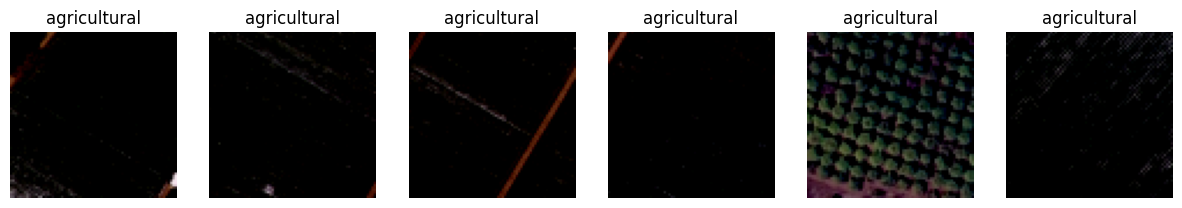

In [8]:
show_sample_images(dataset)


In [9]:
# Define split ratios
train_ratio = 0.7
val_ratio = 0.1
test_ratio = 0.2


In [10]:
# Calculate split sizes
train_size = int(train_ratio * len(dataset))
val_size = int(val_ratio * len(dataset))
test_size = len(dataset) - train_size - val_size

In [11]:
# Randomly split dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])



In [12]:
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [13]:
print(f"Train size: {len(train_dataset)}, Validation size: {len(val_dataset)}, Test size: {len(test_dataset)}")


Train size: 1470, Validation size: 210, Test size: 420


In [14]:
import torch.nn as nn
import torch.optim as optim

In [15]:
class MLP(nn.Module):
    def __init__(self, input_size=72*72*3, hidden1=512, hidden2=256, num_classes=21):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden2, num_classes)
        self.softmax = nn.LogSoftmax(dim=1)  # Softmax for classification

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten image
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.softmax(self.fc3(x))
        return x


In [16]:
# Initialize model
model = MLP()


In [17]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [18]:
num_epochs = 20


In [20]:
# Check if GPU is available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to the selected device
model.to(device)


MLP(
  (fc1): Linear(in_features=15552, out_features=512, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=256, out_features=21, bias=True)
  (softmax): LogSoftmax(dim=1)
)

In [21]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")



Epoch [1/20], Loss: 2.7572
Epoch [2/20], Loss: 1.8117
Epoch [3/20], Loss: 1.1494
Epoch [4/20], Loss: 0.8711
Epoch [5/20], Loss: 0.5765
Epoch [6/20], Loss: 0.3885
Epoch [7/20], Loss: 0.3300
Epoch [8/20], Loss: 0.3215
Epoch [9/20], Loss: 0.2308
Epoch [10/20], Loss: 0.2206
Epoch [11/20], Loss: 0.2252
Epoch [12/20], Loss: 0.1652
Epoch [13/20], Loss: 0.2158
Epoch [14/20], Loss: 0.1191
Epoch [15/20], Loss: 0.1019
Epoch [16/20], Loss: 0.1019
Epoch [17/20], Loss: 0.0857
Epoch [18/20], Loss: 0.0832
Epoch [19/20], Loss: 0.1205
Epoch [20/20], Loss: 0.2354


In [24]:
# Validation Accuracy Calculation
model.eval()
correct, total = 0, 0

with torch.no_grad():  # Disable gradient computation
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)  # Get predicted class
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

val_acc = 100 * correct / total
print(f"Validation Accuracy: {val_acc:.2f}%")


Validation Accuracy: 30.48%


In [25]:
model.eval()
correct, total = 0, 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_acc = 100 * correct / total
print(f"Test Accuracy: {test_acc:.2f}%")


Test Accuracy: 35.00%


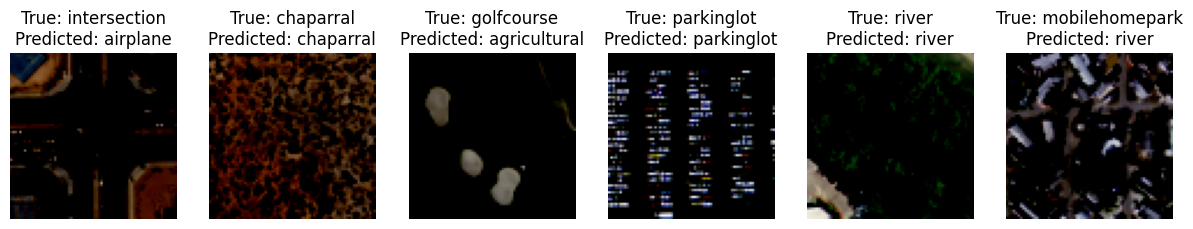

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def show_predictions(model, dataset, num_images=6):
    model.eval()
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

    for i in range(num_images):
        image, label = dataset[i]
        img_tensor = image.unsqueeze(0).to(device)  # Add batch dimension
        output = model(img_tensor)
        _, predicted = torch.max(output, 1)

        image = image.permute(1, 2, 0)  # Convert to HWC format
        axes[i].imshow(image.cpu().numpy().clip(0, 1))  # Clip values to valid range
        axes[i].set_title(f"True: {dataset.dataset.classes[label]}\nPredicted: {dataset.dataset.classes[predicted.item()]}")
        axes[i].axis("off")

    plt.show()

# Call function
show_predictions(model, test_dataset)


In [28]:
import pandas as pd
import torch

# Define list to store results
predictions_list = []

# Run inference on test dataset
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)  # Convert logits to probabilities
        _, predicted = torch.max(outputs, 1)

        # Store results
        for i in range(len(labels)):
            predictions_list.append({
                "True_Label": dataset.classes[labels[i].item()],
                "Predicted_Label": dataset.classes[predicted[i].item()],
                "Confidence": probabilities[i][predicted[i]].item()  # Get confidence of prediction
            })

# Convert to DataFrame
df = pd.DataFrame(predictions_list)

# Save to CSV
df.to_csv("model_predictions.csv", index=False)
print("Predictions saved to model_predictions.csv")


Predictions saved to model_predictions.csv


In [29]:
import os
import torchvision.utils as vutils

# Create a directory to store misclassified images
misclassified_dir = "misclassified_images"
os.makedirs(misclassified_dir, exist_ok=True)

# Iterate through test dataset again to save misclassified images
misclassified_count = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        for i in range(len(labels)):
            if predicted[i] != labels[i]:  # If misclassified
                img_name = f"{misclassified_count}_true_{dataset.classes[labels[i].item()]}_pred_{dataset.classes[predicted[i].item()]}.png"
                img_path = os.path.join(misclassified_dir, img_name)

                # Save image
                vutils.save_image(images[i], img_path)
                misclassified_count += 1

print(f"Saved {misclassified_count} misclassified images in '{misclassified_dir}'")


Saved 273 misclassified images in 'misclassified_images'


In [30]:
from google.colab import files
files.download("model_predictions.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [31]:
import shutil

# Zip the misclassified images directory
shutil.make_archive("misclassified_images", 'zip', "misclassified_images")

# Download the ZIP file
files.download("misclassified_images.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>